In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

Epoch 0 | Normalized Loss: 0.053467 | Real RMSE: ₩2289.31
Epoch 5 | Normalized Loss: 0.010890 | Real RMSE: ₩1540.87
Epoch 10 | Normalized Loss: 0.009409 | Real RMSE: ₩1584.27
Epoch 15 | Normalized Loss: 0.008413 | Real RMSE: ₩1368.68
Epoch 20 | Normalized Loss: 0.007879 | Real RMSE: ₩1315.69
Epoch 25 | Normalized Loss: 0.007358 | Real RMSE: ₩1279.58

✅ LSTM 예측 RMSE (역변환 후): 1086.75 원


/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_6985/3089123448.py:132: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/iujung/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


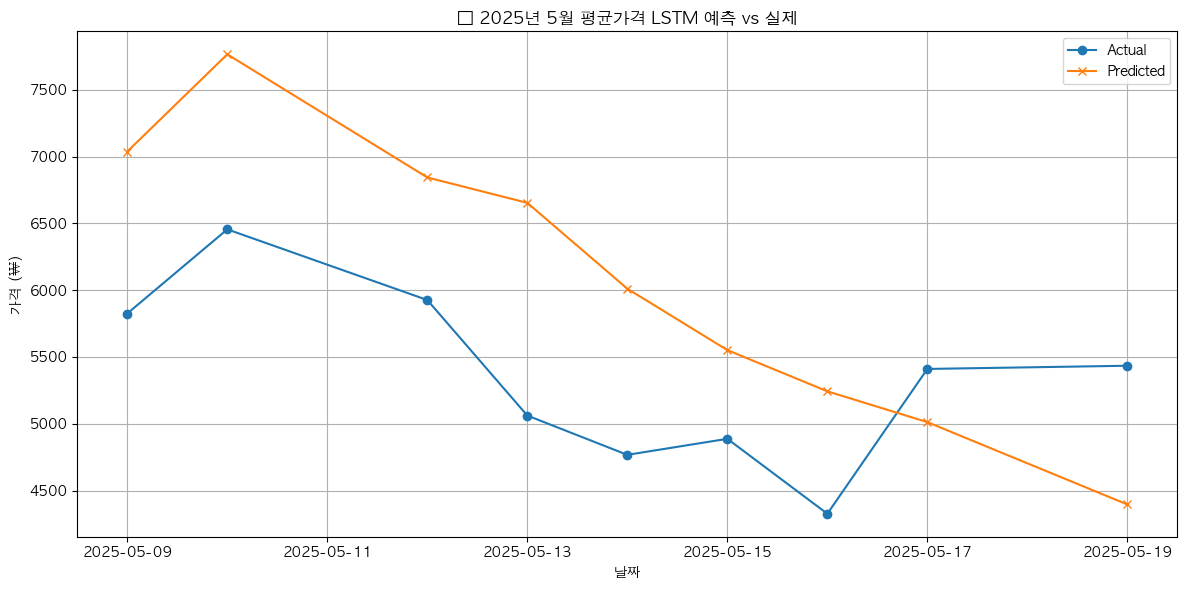

/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_6985/3089123448.py:141: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/iujung/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


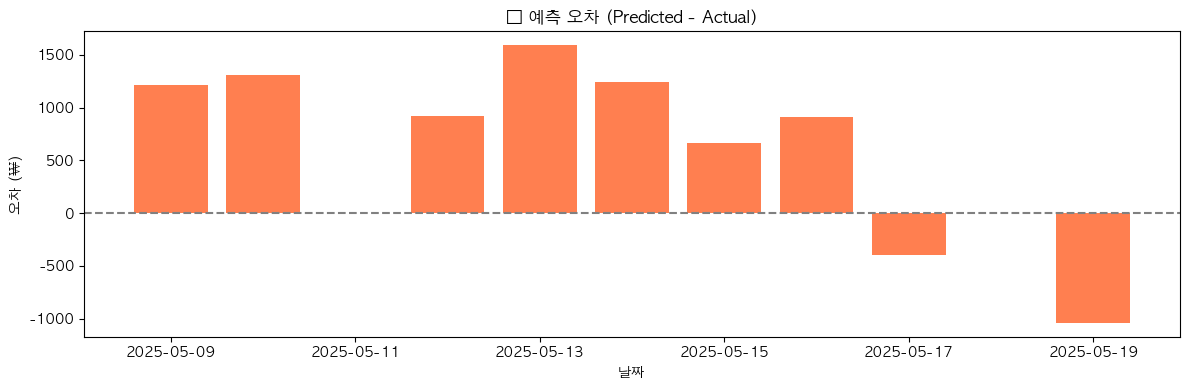

In [6]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 2. 데이터 불러오기
df = pd.read_csv("cabbage_HIGH_2020to2025_JanToMay.csv")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

# 3. 파생 변수 생성
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df.loc[df['weekday'] == 6, 'avg_price'] = 0
df['target'] = df['avg_price'].shift(-1)

for lag in [1, 2, 3, 7]:
    df[f'avg_price_lag{lag}'] = df['avg_price'].shift(lag)
    df[f'intake_lag{lag}'] = df['intake'].shift(lag)
    df[f'gap_lag{lag}'] = df['gap'].shift(lag)

df['avg_price_change_lag1'] = df['avg_price'] / df['avg_price_lag1'] - 1
df['intake_change_lag1'] = df['intake'] / df['intake_lag1'] - 1
df['price_ma7_diff'] = df['avg_price'] - df['avg_price_lag7']
df = df.dropna().copy()

# 4. 피처 및 타겟 정의
feature_cols = [col for col in df.columns if (
    'lag' in col or 'change' in col or 'diff' in col or col in ['weekday', 'is_weekend']
) and 'target' not in col]

train_df = df[(df['year'] < 2025) | ((df['year'] == 2025) & (df['month'] < 5))]
test_df = df[(df['year'] == 2025) & (df['month'] == 5)]

# 입력 정규화
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(train_df[feature_cols])
X_test = x_scaler.transform(test_df[feature_cols])

# 타겟 정규화
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(train_df[['target']])
y_test = y_scaler.transform(test_df[['target']])

# 5. 시퀀스 생성
def create_sequences(X, y, seq_length=7):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(xs), np.array(ys)

seq_len = 7
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_len)

# 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32).squeeze())
test_dataset = TensorDataset(torch.tensor(X_test_seq, dtype=torch.float32),
                             torch.tensor(y_test_seq, dtype=torch.float32).squeeze())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 6. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1])
        return out.squeeze()

model = LSTMModel(input_size=X_train_seq.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. 학습 루프 (정규화된 loss + 실제 RMSE 값 표시)
for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    
    # 🔄 역정규화된 RMSE도 출력
    with torch.no_grad():
        pred_scaled = model(torch.tensor(X_train_seq, dtype=torch.float32))
        pred_real = y_scaler.inverse_transform(pred_scaled.detach().numpy().reshape(-1, 1)).flatten()
        y_real = y_scaler.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()
        true_rmse = np.sqrt(mean_squared_error(y_real, pred_real))

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Normalized Loss: {avg_loss:.6f} | Real RMSE: ₩{true_rmse:.2f}")


# 8. 예측
model.eval()
with torch.no_grad():
    preds_scaled = model(torch.tensor(X_test_seq, dtype=torch.float32)).numpy()

# 9. 역변환
preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
y_test_real = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# 10. RMSE 및 시각화
rmse = np.sqrt(mean_squared_error(y_test_real, preds))
print(f"\n✅ LSTM 예측 RMSE (역변환 후): {rmse:.2f} 원")

dates = test_df['date'].values[seq_len:]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_real, label='Actual', marker='o')
plt.plot(dates, preds, label='Predicted', marker='x')
plt.title("📈 2025년 5월 평균가격 LSTM 예측 vs 실제")
plt.xlabel("날짜")
plt.ylabel("가격 (₩)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(dates, preds - y_test_real, color='coral')
plt.axhline(0, color='gray', linestyle='--')
plt.title("📉 예측 오차 (Predicted - Actual)")
plt.xlabel("날짜")
plt.ylabel("오차 (₩)")
plt.tight_layout()
plt.show()
